In [167]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_curve, mean_squared_error 

from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.linear_model import LogisticRegression

In [168]:
#Veriyi temizle ve filitrele
def clear_data(df, sample_size = 0, number_of_most_played_games = 200):
    #Veriyi Temizle ve Duzenle

    if sample_size > 0:
        df = df.sample(n = sample_size)# Test ederken boyutunu kucult

    df = df[['id', 'opening_name', 'white_rating', 'black_rating', 'winner']]#kullanacagin kolonlari al
    df = df.set_index('id')


    most_played_games = df['opening_name'].value_counts().sort_values().tail(number_of_most_played_games).keys()
    df = df.loc[df['opening_name'].isin(most_played_games)]#Cok az ornegi olan satirlari ele.

    df['opening_name'] = df['opening_name'].str.strip().str.replace(r'(:.\|)|(:.)', '', regex = True)#Acilista onemsiz varyasyonlarini gormezden gel. Regular Expression kullanarak filitreledim
    df['opening_name'] = df['opening_name'].str.wrap(15)#Okunurlugu artir. Yoksa grafiklerde labellar tasiyor.



    #df = df[df['rated'] == True]
    df = df[abs(df['white_rating'] - df['black_rating']) < 100]#Elo'lar arasindaki farkin cok olmasi istenilen bir durum degil

    lowestElo, highestElo = df['white_rating'].min(), df['white_rating'].max() 

    lowestElo = int(lowestElo / 100) * 100
    highestElo = int(highestElo / 100) * 100 + 100

     #Elo araliklari icin yeni kolon olusturdum.
    df['rating_range'] = np.nan

    for elo in range(lowestElo, highestElo, 100):
        df['rating_range'] = np.where(df['white_rating'].between(elo, elo + 100), f'{elo}-{elo + 100}', df['rating_range'])

    #print(df['rating_range'].unique())


    return df

In [169]:
#Label'lara karsilik numerik deger ata
def encode_labels(df):
    labelencoder = LabelEncoder()

    dfc = df.copy()
    dfc['opening_name'] = labelencoder.fit_transform(df['opening_name'])
    dfc['rating_range'] = labelencoder.fit_transform(df['rating_range'])
    dfc['winner'] = labelencoder.fit_transform(df['winner'])



    return dfc


In [170]:
def split_train_and_test(df, test_size = 0.25):#Dorte birini test verisi olarak al
    x = df[['opening_name', 'white_rating', 'black_rating', 'rating_range']]
    y = df['winner']
    return train_test_split(x, y, test_size = test_size, random_state = 42) #Veriyi test ve train olarak ikiye ayir.


In [171]:
def train(model, x_train, x_test, y_train, y_test):
    model = model.fit(x_train, y_train)
    return model.predict(x_test)

In [172]:

#Train ve Validation Hatasi    
def calc_metrics(x_train, y_train, x_test, y_test, model):
    model.fit(x_train, y_train)

    predictions = model.predict(x_train)
    train_error = mean_squared_error(y_train, predictions)#Train Hatasi

    predictions = model.predict(x_test)
    validation_error = mean_squared_error(y_test, predictions)#Validation Hatasi
    
    return train_error, validation_error

In [173]:
def get_metrics(y_actual, y_pred, print_confussion_matrix = False):
    #white, black, draw olmak uzere uc cesit label var
    #confusion matrix 3x3 olacak
    labels = np.unique(y_actual)

    cm = confusion_matrix(y_actual, y_pred, labels = labels)
    fp = cm.sum(axis=0) - np.diag(cm)#false positive
    fn = cm.sum(axis=1) - np.diag(cm)#false negative
    tp = np.diag(cm)#true positive
    tn = cm.sum() - (fp + fn + tp)#true negative

    if(print_confussion_matrix):
        print("----Confusion Matrix----\n")
        print(pd.DataFrame(cm, index = labels, columns = labels))
        print('\n')

    acc = (tp + tn) / (tp + fp + tn + fn)#Dogruluk degerini hesapla
    recall = (tp + tn) / (tp + fp + tn + fn)
    specifity = tn / (tn + fp)
    f_score = 2 * tp / (2 * tp + fp + fn)
        

    fpr, tpr, _ = roc_curve(y_actual, y_pred, pos_label=0)
    fpr1, tpr1, _ = roc_curve(y_actual, y_pred, pos_label=1)
    fpr2, tpr2, _ = roc_curve(y_actual, y_pred, pos_label=2)


    return acc, recall, specifity, f_score, [np.sort(fpr), np.sort(fpr1), np.sort(fpr2)], [np.sort(tpr), np.sort(tpr1), np.sort(tpr2)]


In [174]:
df = pd.read_csv("../datasets/games.csv")
df = clear_data(df)
df = encode_labels(df)

c:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_d

In [175]:
dfc = df.copy()


white_params, black_params, draw_params = [], [], []
ks = []
x_train, x_test, y_train, y_test = split_train_and_test(dfc)
home_work = 7

In [176]:
def add_params(y_pred):
    acc, recall, specifity, f_score, fpr, tpr = get_metrics(y_test, y_pred)

    black_params.append((acc[0], recall[0], specifity[0], f_score[0], fpr[0], tpr[0]))
    draw_params.append((acc[1], recall[1], specifity[1], f_score[1], fpr[1], tpr[1]))
    white_params.append((acc[2], recall[2], specifity[2], f_score[2], fpr[2], tpr[2]))

In [177]:
if home_work == 3: #Odev 3
    for k in range(1, 10):#farkli k degerlerine gore olc
        ks.append(k)
        model = KNeighborsClassifier(n_neighbors=k)

        y_pred = train(model, x_train, x_test, y_train, y_test)
        add_params(y_pred)


In [178]:
if home_work == 4: #Odev 4
    for k in range(1, 10):
        ks.append(k)
        model = GaussianNB(var_smoothing=k * 0.1) #scilearn icerisinde normal naive bayers bulamadim

        y_pred = train(model, x_train, x_test, y_train, y_test)
        add_params(y_pred)

In [179]:
if home_work == 5: #Odev 5.1
    for k in range(1, 10):
        ks.append(k)
        model = DecisionTreeClassifier(max_depth=k)

        y_pred = train(model, x_train, x_test, y_train, y_test)
        add_params(y_pred)

In [180]:
if home_work == 6: #Odev 5.2
    for k in range(1, 10):
        ks.append(k)
        model = DecisionTreeRegressor(max_depth=k) #Veri setimde sayisal degerler de oldugu icin bu algoritmayi kullanamadim

        y_pred = train(model, x_train, x_test, y_train, y_test)
        add_params(y_pred)

In [181]:
if home_work == 7: #Odev 6
    for k in range(1, 1000):
        ks.append(k)
        model = LogisticRegression(max_iter=k)

        y_pred = train(model, x_train, x_test, y_train, y_test)
        add_params(y_pred)

c:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  i

In [182]:
def print_as_table(ks, params):
    for i in range(len(ks)):
        k = ks[i]
        param = params[i]
        print(f"k={k}- accuracy={param[0]}, recall={param[1]}, specifity={param[2]}, f_score={param[3]}")

    fpr = np.sort(np.concatenate([p[4] for p in params]))
    tpr = np.sort(np.concatenate([p[5] for p in params]))
    plt.title('Receiver Operating Characteristic')

    plt.plot(fpr, tpr, 'b')
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')

    plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.



Blacks
k=1- accuracy=0.5577536694320357, recall=0.5577536694320357, specifity=1.0, f_score=0.0
k=2- accuracy=0.44224633056796425, recall=0.44224633056796425, specifity=0.0, f_score=0.6132743362831858
k=3- accuracy=0.44224633056796425, recall=0.44224633056796425, specifity=0.0, f_score=0.6132743362831858
k=4- accuracy=0.5577536694320357, recall=0.5577536694320357, specifity=1.0, f_score=0.0
k=5- accuracy=0.5577536694320357, recall=0.5577536694320357, specifity=1.0, f_score=0.0
k=6- accuracy=0.5577536694320357, recall=0.5577536694320357, specifity=1.0, f_score=0.0
k=7- accuracy=0.5577536694320357, recall=0.5577536694320357, specifity=1.0, f_score=0.0
k=8- accuracy=0.5577536694320357, recall=0.5577536694320357, specifity=1.0, f_score=0.0
k=9- accuracy=0.5583918315252074, recall=0.5583918315252074, specifity=0.8421052631578947, f_score=0.2865979381443299
k=10- accuracy=0.5456285896617741, recall=0.5456285896617741, specifity=0.6807780320366132, f_score=0.42207792207792205
k=11- accuracy=0

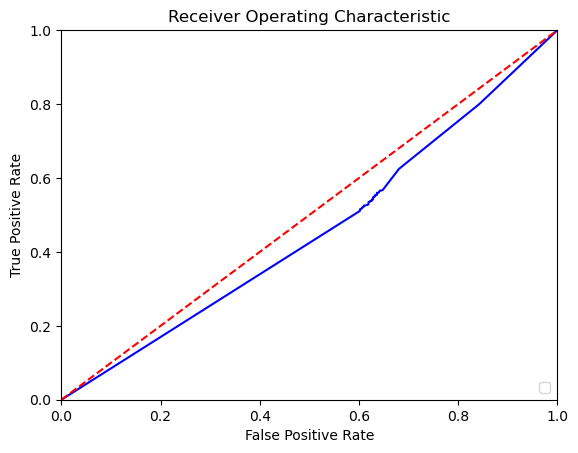

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.



Draws
k=1- accuracy=0.9355456285896617, recall=0.9355456285896617, specifity=1.0, f_score=0.0
k=2- accuracy=0.9355456285896617, recall=0.9355456285896617, specifity=1.0, f_score=0.0
k=3- accuracy=0.9355456285896617, recall=0.9355456285896617, specifity=1.0, f_score=0.0
k=4- accuracy=0.9355456285896617, recall=0.9355456285896617, specifity=1.0, f_score=0.0
k=5- accuracy=0.9355456285896617, recall=0.9355456285896617, specifity=1.0, f_score=0.0
k=6- accuracy=0.9355456285896617, recall=0.9355456285896617, specifity=1.0, f_score=0.0
k=7- accuracy=0.9355456285896617, recall=0.9355456285896617, specifity=1.0, f_score=0.0
k=8- accuracy=0.9355456285896617, recall=0.9355456285896617, specifity=1.0, f_score=0.0
k=9- accuracy=0.9355456285896617, recall=0.9355456285896617, specifity=1.0, f_score=0.0
k=10- accuracy=0.9355456285896617, recall=0.9355456285896617, specifity=1.0, f_score=0.0
k=11- accuracy=0.9355456285896617, recall=0.9355456285896617, specifity=1.0, f_score=0.0
k=12- accuracy=0.935545

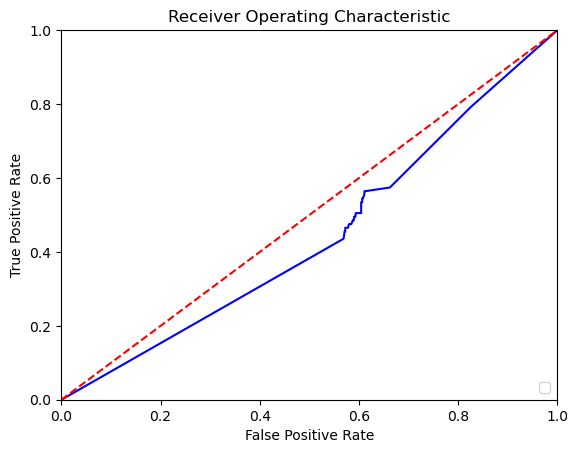

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.



Whites
k=1- accuracy=0.49329929802169753, recall=0.49329929802169753, specifity=0.0, f_score=0.6606837606837607
k=2- accuracy=0.5067007019783025, recall=0.5067007019783025, specifity=1.0, f_score=0.0
k=3- accuracy=0.5067007019783025, recall=0.5067007019783025, specifity=1.0, f_score=0.0
k=4- accuracy=0.49329929802169753, recall=0.49329929802169753, specifity=0.0, f_score=0.6606837606837607
k=5- accuracy=0.49329929802169753, recall=0.49329929802169753, specifity=0.0, f_score=0.6606837606837607
k=6- accuracy=0.49329929802169753, recall=0.49329929802169753, specifity=0.0, f_score=0.6606837606837607
k=7- accuracy=0.49329929802169753, recall=0.49329929802169753, specifity=0.0, f_score=0.6606837606837607
k=8- accuracy=0.49329929802169753, recall=0.49329929802169753, specifity=0.0, f_score=0.6606837606837607
k=9- accuracy=0.5207402680280792, recall=0.5207402680280792, specifity=0.20151133501259447, f_score=0.635967038293747
k=10- accuracy=0.5373324824505424, recall=0.5373324824505424, specif

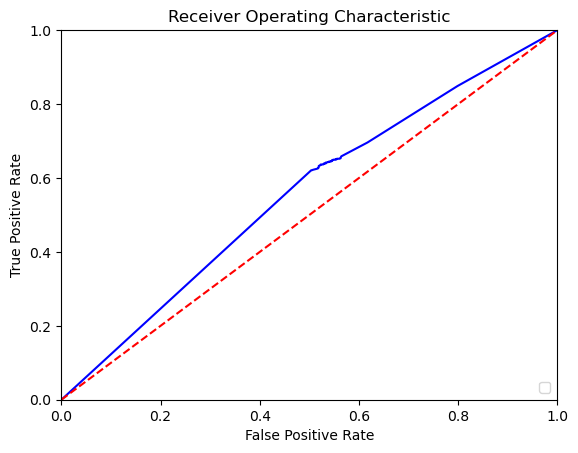

In [183]:
print("\nBlacks")
print_as_table(ks, black_params)
print("\nDraws")
print_as_table(ks, draw_params)
print("\nWhites")
print_as_table(ks, white_params)

In [184]:
def print_gini_impurity(label:str, y: pd.Series):
    p = y.value_counts()/y.shape[0]
    gini = 1-np.sum(p**2)
    print(f"{label}= {gini}")

In [185]:
print_gini_impurity("Acilis Adi", dfc.opening_name)
print_gini_impurity("Beyaz ELO(Puani)", dfc.white_rating)
print_gini_impurity("Siyah ELO(Puani)", dfc.black_rating)
print_gini_impurity("ELO Araligi", dfc.rating_range)
print_gini_impurity("Kazanan", dfc.winner)


Acilis Adi= 0.9908053830963879
Beyaz ELO(Puani)= 0.9970799808347636
Siyah ELO(Puani)= 0.9972935674714225
ELO Araligi= 0.8780935805932727
Kazanan= 0.5479537911195027


In [186]:
#Entropy
classes = pd.unique(dfc.winner).tolist()
occurance = dfc['winner'].value_counts()

r = 0
for o in occurance:
    p = o / dfc.size
    r -= np.log2(p) * p

print("Entropi= " + str(p))

Entropi= 0.01053303542930099
